In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score # métrica de evaluación
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder 


import numpy as np

import sys
sys.path.append('../Code')
from sklearn import metrics
from CustomTransformers import CollinearityDropper

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pokengineer/DataScience/main/datasets/asteroids_nasa.csv')
#df.drop([],axis=1, inplace=True)


Quito variables del tipo fecha que me van a afectar si pretendo escalar ademas de ids

In [3]:
df.drop(['Close Approach Date', 
         'Epoch Date Close Approach', 
         'Orbiting Body',
         'Equinox', 
         'Name', 
         "Neo Reference ID",
         "Orbit Determination Date",
         "Orbit ID"], axis=1, inplace=True)

In [4]:
pfd = CollinearityDropper(columns=df.select_dtypes(include=['int', 'float']).columns, min_coef=0.9)
pfd.fit(df)
df = pfd.transform(df)
#df_nasa[df_nasa.select_dtypes(include=['int', 'float']).columns].corr()
df.shape

(4687, 15)

In [5]:
df.head()

,Absolute Magnitude,Est Dia in KM(min),Relative Velocity km per sec,Miss Dist.(Astronomical),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Inclination,Asc Node Longitude,Perihelion Distance,Perihelion Arg,Mean Anomaly,Hazardous
0,21.6,0.127220,6.115834,0.419483,5,0.025282,4.634,2458000.5,0.425549,6.025981,314.373913,0.808259,57.257470,264.837533,True
1,21.3,0.146068,18.113985,0.383014,3,0.186935,5.457,2458000.5,0.351674,28.412996,136.717242,0.718200,313.091975,173.741112,False
2,20.3,0.231502,7.590711,0.050956,0,0.043058,4.557,2458000.5,0.348248,4.237961,259.475979,0.950791,248.415038,292.893654,True
3,27.4,0.008801,11.173874,0.285322,6,0.005512,5.093,2458000.5,0.216578,7.905894,57.173266,0.983902,18.707701,68.741007,False
4,21.6,0.127220,9.840831,0.407832,1,0.034798,5.154,2458000.5,0.210448,16.793382,84.629307,0.967687,158.263596,135.142133,True


In [6]:
X = df.drop('Hazardous', axis=1)
y = df['Hazardous']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=0)
ss = StandardScaler()
ss.fit(X_train)
X_train = pd.DataFrame(ss.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(ss.transform(X_test), columns=X_test.columns, index=X_test.index)

En este ejemplo se demuestra lo costoso que puede ser esta técnica cuando se usa con un estimador "Lazy"

In [8]:
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(weights='distance', n_neighbors=33, metric='manhattan')
model.fit(X_train, y_train)

result = permutation_importance(estimator=model, X=X_test, y=y_test, n_repeats=10, random_state=0)

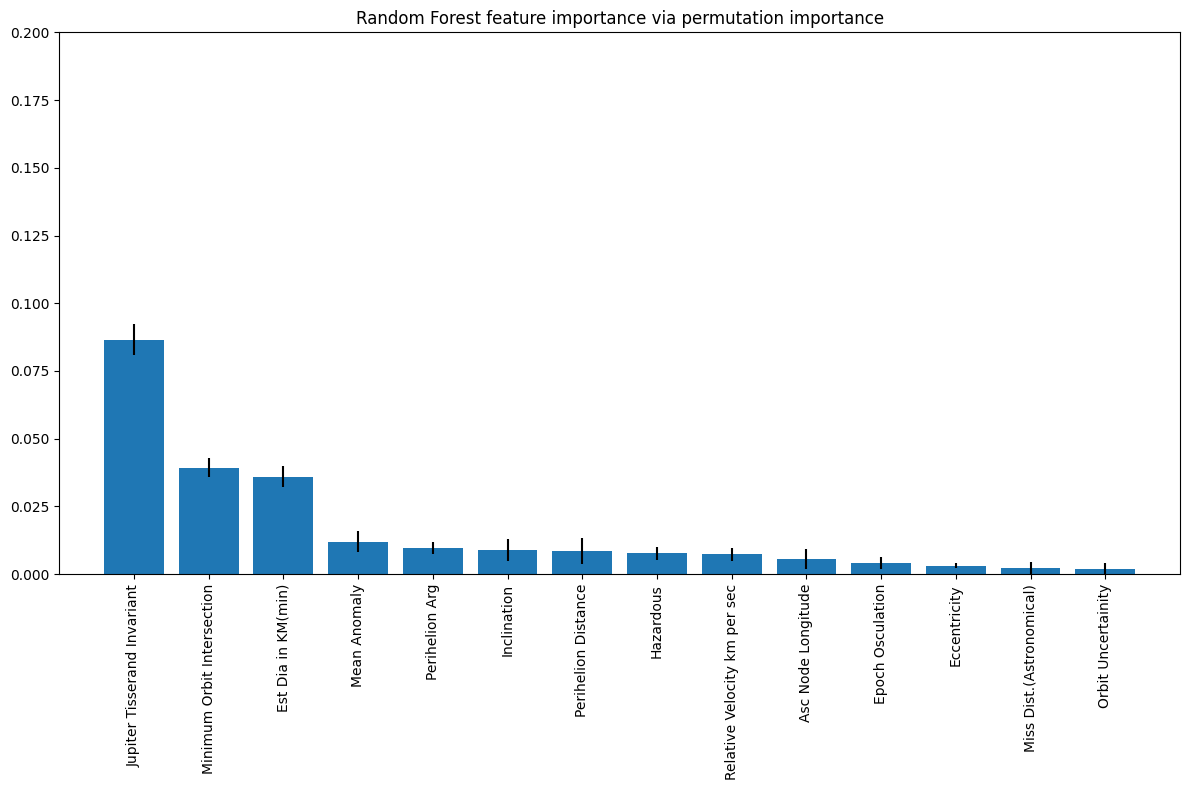

In [9]:
indices = np.argsort(result['importances_mean'])[::-1]

plt.figure(figsize=(12, 8))
plt.title("Random Forest feature importance via permutation importance")
plt.bar(
    range(X_train.shape[1]),
    result['importances_mean'][indices],
    yerr=result['importances_std'][indices]
)

feature_names = np.array(list(df.columns[1:])+['random'])
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylim([0, 0.2])

plt.tight_layout()
plt.show()

In [10]:
X_train.columns

Index(['Absolute Magnitude', 'Est Dia in KM(min)',
       'Relative Velocity km per sec', 'Miss Dist.(Astronomical)',
       'Orbit Uncertainity', 'Minimum Orbit Intersection',
       'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity',
       'Inclination', 'Asc Node Longitude', 'Perihelion Distance',
       'Perihelion Arg', 'Mean Anomaly'],
      dtype='str')

Porque Jupiter Tisserand Invariant: "Cuan estable es la orbita", si Jupiter tiene una influencia importante entonces la orbita se puede volver inestable (Las órbitas en estos cuerpos pequeños no se calculan analiticamente y necesitan cálculo numérico).</BR>
Porque Minimun Orbit Intersection: Si las órbitas no se cruzan, no hay peligrosidad, aunque el objeto sea grande ¿La órbita incluye la influencia de jupiter?.</BR>
Est. Dia in KM(min): Objetos pequeños nos son peligrosos, la atmosfera los desintegra.</BR>

In [11]:
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X[['Jupiter Tisserand Invariant','Minimum Orbit Intersection', 'Est Dia in KM(min)']], y, test_size=0.3, stratify = y, random_state=0)
ss = StandardScaler()
ss.fit(X_train)
X_train.loc[:,X_train.columns] = ss.transform(X_train)
X_test.loc[:,X_train.columns]= ss.transform(X_test)

model = KNeighborsClassifier(weights='distance', n_neighbors=33, metric='manhattan')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
creport = classification_report(y_test,y_pred)
print(creport)
 

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1180
        True       0.99      0.93      0.96       227

    accuracy                           0.99      1407
   macro avg       0.99      0.97      0.98      1407
weighted avg       0.99      0.99      0.99      1407

